In [1]:
from myPackage.my_module import *
from scipy import optimize

### Projection definition

In [2]:
def wer(th, v=1, base='psim'):
    '''
    Creates Werner state based on parameters of angle, visibility and Bell state
    Args:
        th: angle
        v: visibility (default=1)
        base: which Bell state to choose. Accepts one of the strings: "psip", "psim", "phip", "phim"
        which means phi/psi with plus (p) or minus (m) sign (default="psim")
    Returns:
        4x4 np.ndarray
    
    '''
    match base:
        case 'psim':
            vec = np.sin(th)*OneZero - np.cos(th)*ZeroOne
        case 'psip':
            vec = np.sin(th)*OneZero + np.cos(th)*ZeroOne
        case 'phip':
            vec = np.sin(th)*OneOne + np.cos(th)*ZeroZero
        case 'phim':
            vec =np.sin(th)*OneOne - np.cos(th)*ZeroZero
        case _:
            raise ValueError("You must choose one of the following: psip, psim, phip, phim")
    return v * np.outer(vec,vec) + (1-v)/4 * np.identity(4)

In [3]:
def non_opt_phi_proj(matrixA):
    def get_params_phi(matrix):
        v = 1 - 4*matrix[1,1]
        if v==0:
            return 0, 0    
        alph = np.arcsin(matrix[0,3]/v*2)/2
        return alph, v
       
    def projection(matrix):
        return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                    [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                    [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                    [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))
    
    matrix_proj = projection(matrixA)
    angle, vis = get_params_phi(matrix_proj)
    dist = Frobenius_dist(matrix_proj, matrixA)
    conc = concurrence(density_matrix(matrix_proj))
    conc_org = concurrence(density_matrix(matrixA))
    fid = matrix_fidelity(matrixA, matrix_proj)   
    return {'distance': dist, 'concurrence' : conc, 'fidelity': fid,\
            'angle': angle, 'visibility': vis, 'projected': matrix_proj, 'original': matrixA, 'concurrence_org':conc_org}

In [4]:
def projection(matrix):
        return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                  [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                  [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                  [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))


def phi_proj(matrixA, target='fidelity'):
    '''
    Performs a unitary rotation and projects onto phi+ state (optimizes for fidelity, distance or concurrence)
    Args:
        matrixA: matrix to be projected
        target: function to be optimizes for. One of the following: 'fidelity', 'distance' or 'concurrence'
    Returns:
        A dict object:
            fidelity/distance/concurrence: optimal value of the target function
            parameters: 2x3 angles of unitary rotation
            angle: angle of resulting phi+ state
            visiblity: visibility of resulting phi+ state
            projected: np.matrix result of projection
            original: np.matrix original matrix
    '''
    def get_params_phi(matrix):
        v = 1 - 4*matrix[1,1]
        if v==0:
            return 0, 0    
        alph = np.arcsin(matrix[0,3]/v*2)/2
        return alph, v
    
    
    from scipy.optimize import differential_evolution
    
    def f(params, matrixA):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        paramsA = params[:3]
        paramsB = params[3:]
        rotated = rotate_matrix(matrixA, paramsA, paramsB)
        projected = projection(rotated)
        if target=='fidelity':
            return -1*matrix_fidelity(density_matrix(projected), matrixA)
        if target=='concurrence':
            return -1*concurrence(projected)
        if target=='distance':
            return Frobenius_dist(matrixA, projected)
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = differential_evolution(f, args=(matrixA,), bounds=bounds)
    
    if target=='distance':
        res['fun'] = -res['fun']
        
    paramsA = res['x'][:3]
    paramsB = res['x'][3:]
    matrix_proj = projection(rotate_matrix(matrixA, paramsA, paramsB))
    angle, vis = get_params_phi(matrix_proj)
    dist = Frobenius_dist(matrix_proj, matrixA)
    conc = concurrence(density_matrix(matrix_proj))
    conc_org = concurrence(density_matrix(matrixA))
    fid = matrix_fidelity(matrixA, matrix_proj)   
    return {'distance': dist, 'concurrence' : conc, 'fidelity': fid,\
            'parameters': [paramsA, paramsB], 'angle': angle,\
            'visibility': vis, 'projected': matrix_proj, 'original': matrixA, 'target': target, 'concurrence_org':conc_org}
    
    
    
def phi_proj2(matrixA, target='fidelity'):
    '''
    Performs a unitary rotation and projects onto phi+ state (optimizes for fidelity, distance or concurrence)
    Args:
        matrixA: matrix to be projected
        target: function to be optimizes for. One of the following: 'fidelity', 'distance' or 'concurrence'
    Returns:
        A dict object:
            fidelity/distance/concurrence: optimal value of the target function
            parameters: 2x3 angles of unitary rotation
            angle: angle of resulting phi+ state
            visiblity: visibility of resulting phi+ state
            projected: np.matrix result of projection
            original: np.matrix original matrix
    '''
    def get_params_phi(matrix):
        v = 1 - 4*matrix[1,1]
        if v==0:
            return 0, 0    
        alph = np.arcsin(matrix[0,3]/v*2)/2
        return alph, v
    
    
    from scipy.optimize import differential_evolution
        
    def f(params, matrixA):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        paramsA = params[:3]
        paramsB = params[3:]
        projected = projection(matrixA)
        rotated = rotate_matrix_par(projected, paramsA, paramsB)
        if target=='fidelity':
            return -1*matrix_fidelity(density_matrix(rotated), matrixA)
        if target=='concurrence':
            return -1*concurrence(rotated)
        if target=='distance':
            return Frobenius_dist(matrixA, rotated)
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = differential_evolution(f, args=(matrixA,), bounds=bounds, workers=1)
    
    if target=='distance':
        res['fun'] = -res['fun']
        
    paramsA = res['x'][:3]
    paramsB = res['x'][3:]
    matrix_proj =rotate_matrix_par(projection(matrixA), paramsA, paramsB)
    angle, vis = get_params_phi(matrix_proj)
    dist = Frobenius_dist(matrix_proj, matrixA)
    conc = concurrence(density_matrix(matrix_proj))
    conc_org = concurrence(density_matrix(matrixA))
    fid = matrix_fidelity(matrixA, matrix_proj)   
    return {'distance': dist, 'concurrence' : conc, 'fidelity': fid,\
            'parameters': [paramsA, paramsB], 'angle': angle,\
            'visibility': vis, 'projected': matrix_proj, 'original': matrixA, 'target': target, 'concurrence_org':conc_org}    

In [5]:
phi_proj2(wer(pi/4,1, 'phip'),'distance')

{'distance': 2.909572094846027e-19,
 'concurrence': 1.0,
 'fidelity': 0.9999999999999991,
 'parameters': [array([3.14159, 1.95107, 4.32242]),
  array([3.14159, 4.33211, 1.96076])],
 'angle': (0.7853981633877162+1.0536716622258602e-08j),
 'visibility': (1-2.4117378494372017e-49j),
 'projected': matrix([[ 0.5+0.j, -0. +0.j,  0. +0.j,  0.5+0.j],
         [-0. -0.j,  0. +0.j,  0. -0.j, -0. -0.j],
         [ 0. -0.j,  0. +0.j,  0. +0.j,  0. -0.j],
         [ 0.5-0.j, -0. +0.j,  0. +0.j,  0.5+0.j]]),
 'original': array([[0.5, 0. , 0. , 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0. , 0. , 0.5]]),
 'target': 'distance',
 'concurrence_org': 1.0}

### Data generation & save & read

In [6]:
non_opt_df = pd.DataFrame({'distance':[], 'concurrence':[],'fidelity':[], 'concurrence_org':[]})
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(10000):
        state = rand_PSDM(4)
        res = non_opt_phi_proj(state)
        non_opt_df.loc[len(non_opt_df)] = [res['distance'], res['concurrence'], res['fidelity'], res['concurrence_org']]

In [ ]:
df_raw=pd.DataFrame({'distance':[], 'concurrence':[],'fidelity':[], 'target':[], 'concurrence_org':[]})

In [6]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(10000):
        state = rand_PSDM(4)
        res = phi_proj(state, target='distance')
        df_raw.loc[len(df_raw)] = [res['distance'], res['concurrence'], res['fidelity'], res['target'], res['concurrence_org']]
        res = phi_proj(state, target='fidelity')
        df_raw.loc[len(df_raw)] = [res['distance'], res['concurrence'], res['fidelity'], res['target'], res['concurrence_org']]
        res = phi_proj(state, target='concurrence')
        df_raw.loc[len(df_raw)] = [res['distance'], res['concurrence'], res['fidelity'], res['target'], res['concurrence_org']]
        if i%10 == 99:
            print(f'{i+1} out of 10000 done')    

10 out of 10000 done
20 out of 10000 done
30 out of 10000 done
40 out of 10000 done
50 out of 10000 done
60 out of 10000 done
70 out of 10000 done
80 out of 10000 done
90 out of 10000 done
100 out of 10000 done
110 out of 10000 done
120 out of 10000 done
130 out of 10000 done
140 out of 10000 done
150 out of 10000 done
160 out of 10000 done
170 out of 10000 done
180 out of 10000 done
190 out of 10000 done
200 out of 10000 done
210 out of 10000 done
220 out of 10000 done
230 out of 10000 done
240 out of 10000 done
250 out of 10000 done
260 out of 10000 done
270 out of 10000 done
280 out of 10000 done
290 out of 10000 done
300 out of 10000 done
310 out of 10000 done
320 out of 10000 done
330 out of 10000 done
340 out of 10000 done
350 out of 10000 done
360 out of 10000 done
370 out of 10000 done
380 out of 10000 done
390 out of 10000 done
400 out of 10000 done
410 out of 10000 done
420 out of 10000 done
430 out of 10000 done
440 out of 10000 done
450 out of 10000 done
460 out of 10000 do

KeyboardInterrupt: 

In [8]:
df_raw.to_csv('projection.csv', index=False)
#non_opt_df.to_csv('non_opt_proj.csv', index=False)

In [23]:
df_raw = pd.read_csv('projection.csv')
non_opt_df = pd.read_csv('non_opt_proj.csv')
rot_df = pd.read_csv('rot_test.csv')
df = df_raw.copy(deep=True)

### Projection by integration

In [27]:
def matrix_print(func):
    def wrapper(*args, **kwargs):
        out=func(*args, **kwargs)
        out = np.array(out) if type(out)=='numpy.matrix' else out
        s = [[str(f'{e.real:.3f} + {e.imag:.3f}i ') for e in row] for row in out]
        lens = [max(map(len, col)) for col in zip(*s)]
        fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
        table = [fmt.format(*row) for row in s]
        print('\n'.join(table))
    return wrapper

def matrix_print_m(mat):
    mat = np.array(mat) if type(mat)=='numpy.matrix' else mat
    s = [[str(f'{e.real:.3f} + {e.imag:.3f}i ') for e in row] for row in mat]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

def projection(matrix):
        return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                    [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                    [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                    [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))

In [30]:
@matrix_print
def int_projection(dm, N=10000):

    qubit_switch = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
        
    def phase_rotation(phi=np.random.random()*2*pi):
        from scipy.linalg import expm
        sig_z = np.array([[1,0],[0,-1]], dtype='complex')
        U = tens_prod2d(expm((1j * phi * sig_z)), expm((-1j * phi * sig_z)))
        return U
    
    def phase_rotation_dag(phi=np.random.random()*2*pi):
        return np.transpose(np.conjugate(phase_rotation(phi)))
    
    proj = np.zeros(shape=(4,4), dtype='complex')
    dm = dm.matrix if type(dm)=='density_matrix' else dm
    for i in range(N):
        phi=np.random.random()*2*pi
        rotated = phase_rotation(phi)@dm@phase_rotation_dag(phi)
        switched = qubit_switch@rotated@qubit_switch
        proj += (np.transpose(rotated + switched) + rotated + switched)/4
    
    proj = proj/N
    return proj
        
    

In [33]:
def int_projection_conv(dm, N=10000):

    qubit_switch = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
        
    def phase_rotation(phi=np.random.random()*2*pi):
        from scipy.linalg import expm
        sig_z = np.array([[1,0],[0,-1]], dtype='complex')
        U = tens_prod2d(expm((1j * phi * sig_z)), expm((-1j * phi * sig_z)))
        return U
    
    def phase_rotation_dag(phi=np.random.random()*2*pi):
        return np.transpose(np.conjugate(phase_rotation(phi)))
    
    def projection(matrix):
        return np.real(np.matrix([[matrix[0,0],0,0,matrix[0,3]/2+matrix[3,0]/2],\
                                    [0,matrix[2,2]/2+matrix[1,1]/2,0,0],\
                                    [0,0,matrix[2,2]/2+matrix[1,1]/2,0],\
                                    [matrix[0,3]/2+matrix[3,0]/2,0,0,matrix[3,3]]]))        
    
    proj = np.zeros(shape=(4,4), dtype='complex')
    errs = np.zeros(shape = N)
    dm = dm.matrix if type(dm)=='density_matrix' else dm
    for i in range(N):
        phi=np.random.random()*2*pi
        rotated = phase_rotation(phi)@dm@phase_rotation_dag(phi)
        switched = qubit_switch@rotated@qubit_switch
        proj += (np.transpose(rotated + switched) + rotated + switched)/4
        errs[i] = Frobenius_dist(projection(dm), proj/(i+1))
    
    proj = proj/N
    return errs
        

In [21]:
rand_state=rand_PSDM(4)
rand_state

array([[ 0.19092+0.j     , -0.05753-0.17173j, -0.13562-0.02747j,
        -0.06064+0.04164j],
       [-0.05753+0.17173j,  0.36085-0.j     ,  0.08276-0.09518j,
         0.00302+0.01872j],
       [-0.13562+0.02747j,  0.08276+0.09518j,  0.1587 -0.j     ,
        -0.03304-0.08498j],
       [-0.06064-0.04164j,  0.00302-0.01872j, -0.03304+0.08498j,
         0.28953-0.j     ]])

In [49]:
hist=[]
for i in range(5):
    hist.append(int_projection_conv(rand_state, N=1000000))

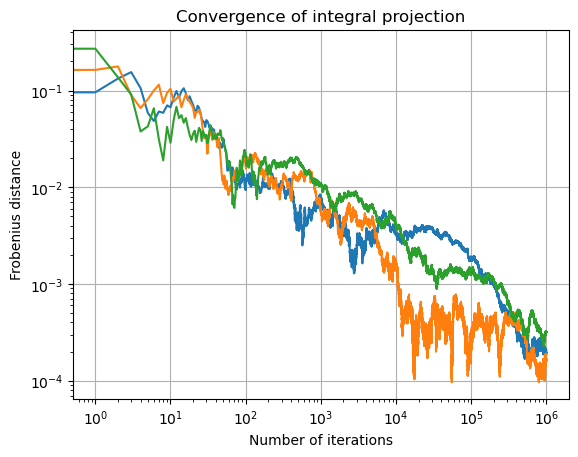

In [54]:
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlabel('Number of iterations')
plt.ylabel('Frobenius distance')
plt.title('Convergence of integral projection')
for i in range(3):
    plt.plot(hist[-i-1])

plt.show()

### Data analysis

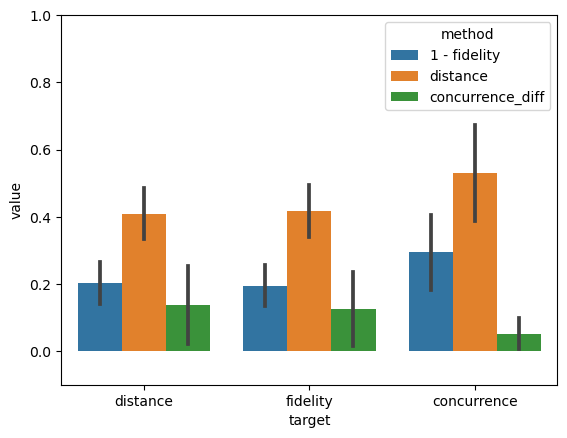

In [40]:
df['concurrence_diff'] = df.concurrence_org - df.concurrence
df.loc[df['concurrence_org']==0, 'concurrence_diff']=np.nan
df['1 - fidelity'] = 1 - df['fidelity']
import seaborn as sns
df_melt=df.melt(['target'], value_vars = ['1 - fidelity', 'distance', 'concurrence_diff'], var_name='method')
df_melt['target'].astype('category')
plt.ylim(-0.1,1)
sns.barplot(data=df_melt,  orient='v', x='target', y='value', hue='method', errorbar='sd', estimator='median')
plt.show()

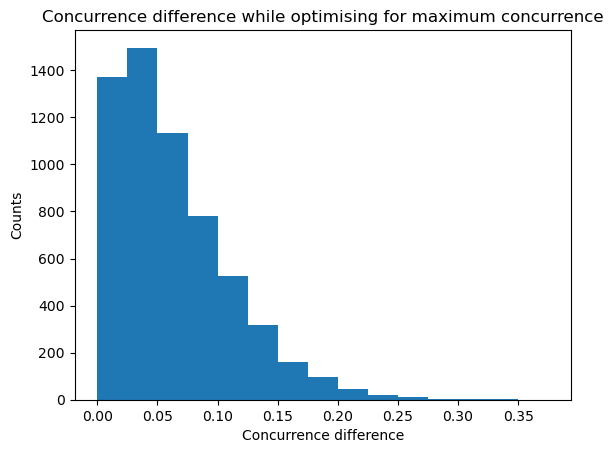

In [25]:
df_melt.loc[np.logical_and(df_melt.target=='concurrence', df_melt.method=='concurrence_diff')].hist(bins = np.arange(0, 0.4, 0.025))
plt.title('Concurrence difference while optimising for maximum concurrence')
plt.xlabel('Concurrence difference')
plt.ylabel('Counts')
plt.grid(False)

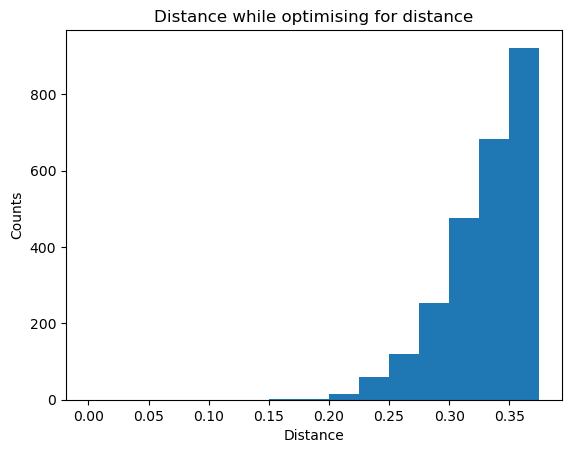

In [41]:
df_melt.loc[np.logical_and(df_melt.target=='distance', df_melt.method=='distance')].hist(bins = np.arange(0, 0.4, 0.025))
plt.title('Distance while optimising for distance')
plt.xlabel('Distance')
plt.ylabel('Counts')
plt.grid(False)

In [44]:
df.distance.describe()

count    23637.000000
mean         0.461682
std          0.121085
min          0.155860
25%          0.380356
50%          0.438455
75%          0.513772
max          1.085513
Name: distance, dtype: float64

In [26]:
df_melt.loc[np.logical_and(df_melt.target=='concurrence', df_melt.method=='concurrence_diff')].describe()

,value
count,5957.000000
mean,0.062877
std,0.047206
min,0.000064
25%,0.026678
50%,0.052280
75%,0.088853
max,0.335414


In [27]:
df_melt.loc[np.logical_and(df_melt.method=='concurrence_diff', df_melt.target.isin(['distance','fidelity']))]

,target,method,value
47274,distance,concurrence_diff,0.038715
47275,fidelity,concurrence_diff,0.038715
47277,distance,concurrence_diff,0.060500
47278,fidelity,concurrence_diff,0.060500
47280,distance,concurrence_diff,0.196274
...,...,...,...
70904,fidelity,concurrence_diff,0.076070
70906,distance,concurrence_diff,0.022180
70907,fidelity,concurrence_diff,0.022180
70909,distance,concurrence_diff,0.199354


<Axes: >

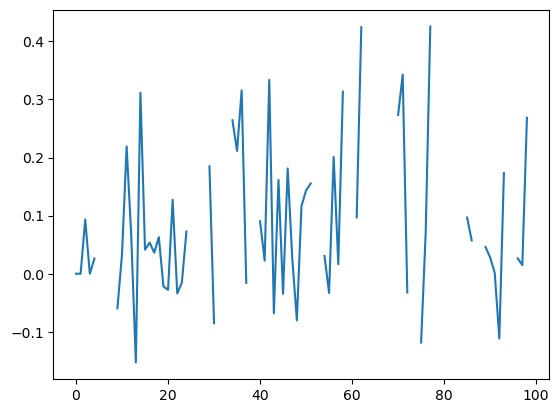

In [37]:
df_dist = df.loc[df.target == 'distance'].reset_index(drop=True)
df_fid = df.loc[df.target == 'fidelity'].reset_index(drop=True)
df_conc = df.loc[df.target == 'concurrence'].reset_index(drop=True)

(df_dist.concurrence_diff - df_conc.concurrence_diff)[:100].plot()

In [55]:
non_opt_df['conc_diff'] = non_opt_df.concurrence_org - non_opt_df.concurrence
non_opt_df.conc_diff.loc[non_opt_df.concurrence_org == 0 ] = np.nan

<Axes: xlabel='Distance', ylabel='Counts'>

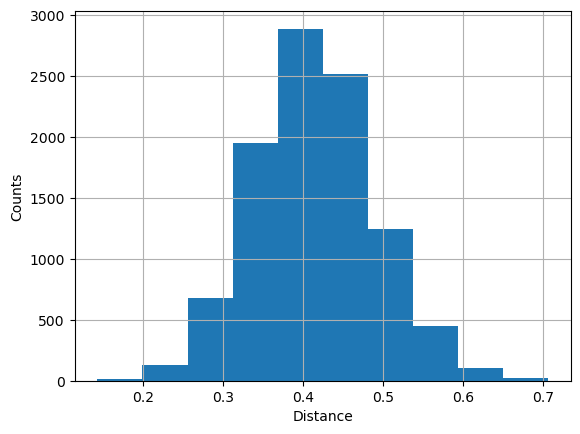

In [63]:

plt.xlabel('Distance')
plt.ylabel('Counts')
plt.grid(False)
non_opt_df.distance.hist()

In [59]:
non_opt_df.conc_diff.describe()

count    7602.000000
mean        0.163414
std         0.115842
min         0.000032
25%         0.071942
50%         0.141412
75%         0.231722
max         0.737025
Name: conc_diff, dtype: float64

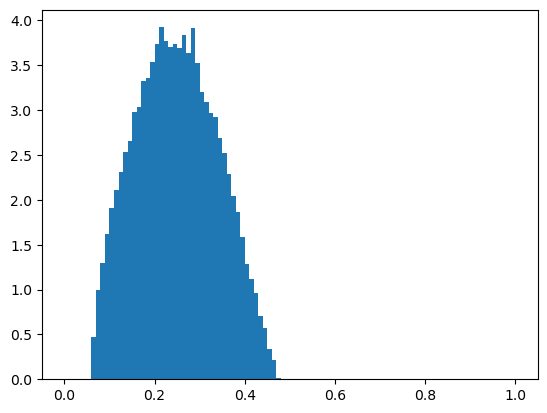

In [21]:
density_matrix(res['original']).histogram()

In [9]:
wer(pi/3, base ='phip')

array([[0.75   , 0.     , 0.     , 0.43301],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.43301, 0.     , 0.     , 0.25   ]])

### Data from another experiment

In [39]:
#tworzy instancje klasy z pięcioma pandas DataFrame
samps = load_samples('all_complex')

In [3]:
#DataFrame z kątem oraz widzialnością znalezionego optymalnego stanu
samps.OptimalState.head()

,Angle,Visibility
Index,,
0,0.285188,0.585148
1,0.460276,0.441305
2,0.437844,0.641831
3,0.107143,0.410110
4,0.217093,0.500638


### Concurrence repair

In [4]:
conc_opt = pd.Series(np.zeros_like(samps.OptimalState.Angle))
for i in range(len(samps.OptimalState.Angle)):
    ang = samps.OptimalState.Angle[i]
    vis = samps.OptimalState.Visibility[i]
    conc_opt[i] = concurrence(density_matrix(rho2(ang, vis)))
samps.Measures.ConcurrenceOpt = conc_opt

0         0.108524
1         0.071904
2         0.313832
3         0.000000
4         0.000000
            ...   
720795    0.281406
720796    0.000000
720797    0.111709
720798    0.193619
720799    0.006491
Length: 720800, dtype: float64

In [30]:
def row_to_dm(samps, idx):
    return density_matrix(np.reshape(samps.Matrix.loc[idx], (4, 4)))
conc = pd.Series(np.zeros_like(samps.Matrix['0,0']))
for idx in range(len(samps.Matrix)):
    conc[idx] = concurrence(row_to_dm(samps, idx))
samps.Measures.ConcurrenceOriginal = conc

In [6]:
samps.Measures.to_csv('allcomplexMeasures.csv', index='Index')

### 

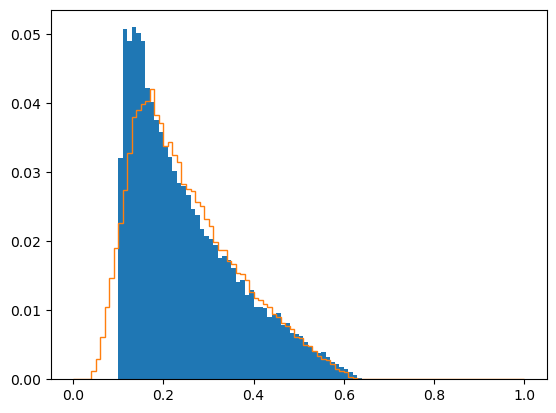

In [9]:
# Metoda do wywoływania histogramu - pomarańczowe schodki to stan losowy, a niebieskie to dopasowany.
# W argumencie jest index próbki
samps.double_plot(0)

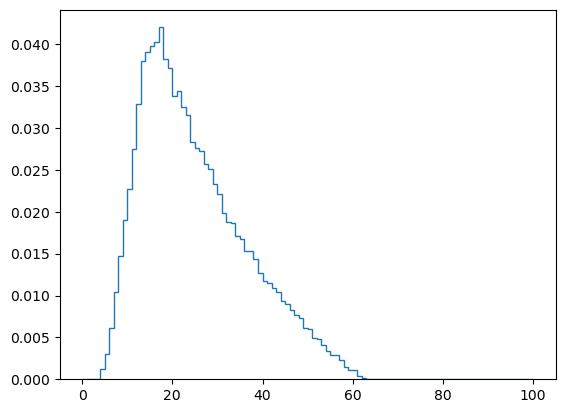

In [10]:
# Histogram tylko stanu losowego
samps.histogram(0)

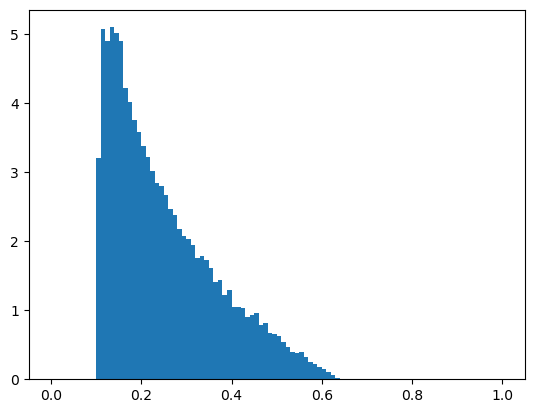

In [11]:
#Histogram tylko stanu dopasowanego
samps.opt_histogram(0)

In [13]:
# Tworzy instancję klasy density_matrix z macierzy stanu losowego
dm = samps.density_matrix(0)

In [15]:
# Tworzy instancję klasy density_matrix ze stanu Wernera o zadanym kącie th i widzialności vis
th=pi/2
vis = 1

wer = density_matrix(rho2(th,vis))

In [18]:
#różne funkcje korzystające z density_matrix
print(matrix_fidelity(dm, wer))
print(Frobenius_dist(dm, wer))
print(concurrence(wer))
print(CHSHviolation_measure(wer))

0.4250876905292271
0.8210858019295816
1.2246467991473532e-16
0.0


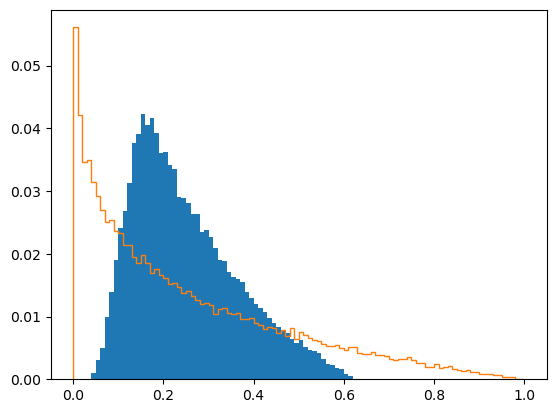

In [19]:
double_plot(dm, wer)

In [53]:
def optimal_trace(dmA):
    from scipy.optimize import differential_evolution, dual_annealing, brute, shgo
    def f(matrixA, params):
        matrixA = matrixA.matrix if type(matrixA) == density_matrix else matrixA
        matrixB = rho2(-pi/4,1)
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.trace(np.matmul(matrixB, rotate_matrix(matrixA, paramsA, paramsB)))
    bounds = [(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)]
    res = differential_evolution(f, args=(dmA,), bounds=bounds)
    return {'value': -np.real(res['fun']), 'parameters': [res['x'][:3], res['x'][3:]]}


In [48]:
def wer_projection(state):
    import scipy.optimize
    
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = scipy.optimize.differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    trace = -1*res['fun']
    
    nonlconstraint = optimize.NonlinearConstraint(lambda x:(x[1]*np.cos(x[0]-np.pi/4)*np.cos(x[0]-np.pi/4)-x[1]/4+1/4-trace),lb=0,ub=0)
    bounds = optimize.Bounds([-pi/4,0], [pi/4, 1])
    def concurrencerho(x):
        rho = rho2(x[0],x[1])  #making sure rho is of np.array type
        rhod = tens_prod2d(Pauli[2], Pauli[2])@np.transpose(np.conjugate(rho))@tens_prod2d(Pauli[2], Pauli[2])
        lambs = np.linalg.eigvals(rho@rhod)
        lambs = np.sqrt(lambs)
        l1 = max(lambs)
        C = 2*l1 - np.sum(lambs)
        return np.real(-C)
    
    return optimize.minimize(concurrencerho,x0=[-pi/4, 1], constraints=nonlconstraint, bounds=bounds, method='trust-constr')

In [12]:
def optimal_trace(state):
    from scipy.optimize import differential_evolution
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    return -res['fun']

In [13]:
optimal_trace(rho2(-pi/4,1))

0.9999999999185996

In [29]:
def wer_projection_dist(state):
    import scipy.optimize
    
    def f(params):
        paramsA = params[:3]
        paramsB = params[3:]
        return -1*np.real(np.trace(np.dot(rotate_matrix(state, paramsA, paramsB), rho2(-pi/4,1))))
    res = scipy.optimize.differential_evolution(f, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])
    trace = -1*res['fun']
    
    nonlconstraint = optimize.NonlinearConstraint(lambda x:(x[1]*np.cos(x[0]-np.pi/4)*np.cos(x[0]-np.pi/4)-x[1]/4+1/4-trace),lb=0,ub=0)
    bounds = optimize.Bounds([0,0,0,0,0,0], [2*pi,2*pi,2*pi,2*pi,2*pi,2*pi])
    def dist(params): 
        paramsA = params[:3]
        paramsB = params[3:]
        D=rotate_matrix(state, paramsA, paramsB) - rho2(-pi/4,1)
        dist=np.sqrt(np.real(np.trace(np.transpose(np.conjugate(D))@D)))
        return dist
    
    return scipy.optimize.differential_evolution(dist, bounds=[(0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi), (0,2*pi)])

In [30]:
wer_projection_dist(rho2(pi/4, 1))

c:\Users\Jan\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 8.804841303259117e-08
                 x: [ 5.725e-02  2.442e+00  2.940e+00  5.725e-02  8.712e-01
                      1.369e+00]
               nit: 1000
              nfev: 7350
              njev: 1050
              nhev: 0
          cg_niter: 1064
      cg_stop_cond: 2
              grad: [ 1.408e+00  2.785e-01 -3.068e-03 -1.405e+00  2.795e-01
                      5.450e-03]
   lagrangian_grad: [-2.907e-03  2.296e-02 -3.228e-03 -5.720e-03  1.107e-01
                     -3.233e-03]
            constr: [array([ 1.110e-16]), array([ 5.725e-02,  2.442e+00,  2.940e+00,  5.725e-02,
                            8.712e-01,  1.369e+00])]
               jac: [array([[ 2.426e+00,  3.071e-01,  0.000e+00,
                             0.000e+00,  0.000e+00,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.0

In [113]:
int_projection(rand_PSDM(4))

0.308 + -0.000i  	0.001 + 0.000i   	-0.001 + 0.001i 	0.179 + -0.127i  
0.001 + -0.000i  	0.215 + 0.000i   	-0.001 + 0.000i 	0.000 + -0.001i  
-0.001 + -0.001i 	-0.001 + -0.000i 	0.255 + 0.000i  	-0.001 + -0.001i 
0.179 + 0.127i   	0.000 + 0.001i   	-0.001 + 0.001i 	0.222 + 0.000i   


0.199 + -0.000i 	0.042 + 0.042i   	0.009 + -0.005i 	0.029 + -0.079i  
0.042 + -0.042i 	0.070 + -0.000i  	-0.046 + 0.123i 	-0.015 + -0.048i 
0.009 + 0.005i  	-0.046 + -0.123i 	0.511 + 0.000i  	-0.156 + -0.004i 
0.029 + 0.079i  	-0.015 + 0.048i  	-0.156 + 0.004i 	0.220 + -0.000i  


# Playground

In [21]:
class experiment(density_matrix):
    
    def __init__(self, rho, name=''):
        super().__init__(rho, name)
    
    def set_proj(self, N=1000000):
        self.data = np.zeros(N)
        n = N//1000
        def phase_rotation(phi=np.random.random()*2*pi):
            from scipy.linalg import expm
            sig_z = np.array([[1,0],[0,-1]], dtype='complex')
            U = tens_prod2d(expm((1j * phi * sig_z)), expm((-1j * phi * sig_z)))
            return U
    
        def phase_rotation_dag(phi=np.random.random()*2*pi):
            return np.transpose(np.conjugate(phase_rotation(phi)))

        qubit_switch = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

        for i in range(1000):
            phi = np.random.random()*2*pi    
            rotated = phase_rotation(phi)@self.matrix@phase_rotation_dag(phi)
            switched = qubit_switch@rotated@qubit_switch
            proj = (np.transpose(rotated + switched) + rotated + switched)/4                      
                        
            for j in range(n):
                self.data[i*n + j] = obs(proj)
        

In [22]:
ex = experiment(rho2(pi/4, 1))
ex.set_proj()
ex.histogram()

KeyboardInterrupt: 

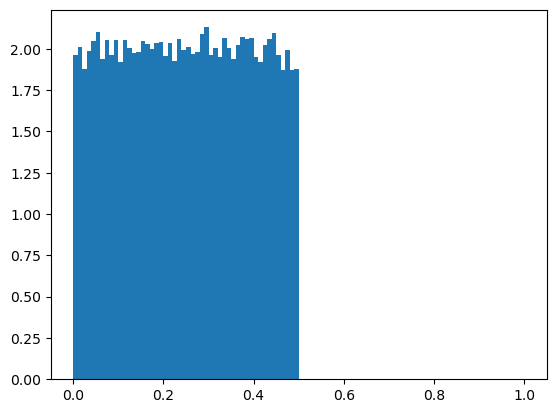

In [20]:
ex.set()
ex.histogram()

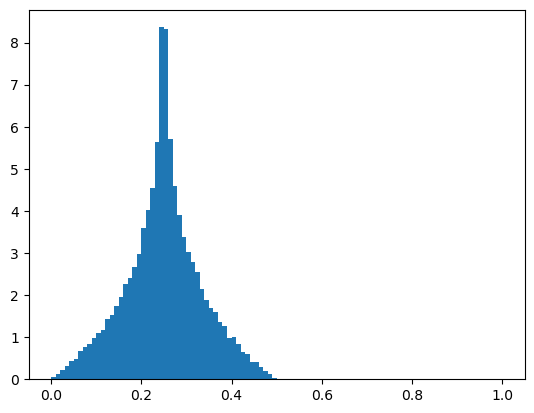

In [16]:
density_matrix(projection(rho2(pi/4,1))).histogram()

In [31]:
all_complex = load_samples('all_complex')

In [36]:
all_complex.Measures

,Distance,MatrixFidelity,HistogramFidelity,Covering,ConcurrenceOriginal,ConcurrenceOpt,CHSHViolationMOriginal,CHSHViolationMOpt,ConcurrenceDiff
Index,,,,,,,,,
0,0.134917,0.948760,0.937120,0.90876,0.114023,0.067022,0.0,0.0,0.047000
1,0.195771,0.911139,0.854492,0.79780,0.000000,0.000000,0.0,0.0,NaN
2,0.105442,0.957498,0.952583,0.93200,0.128604,0.086633,0.0,0.0,0.041971
3,0.256375,0.872250,0.795017,0.76882,0.000000,0.000000,0.0,0.0,NaN
4,0.169950,0.933961,0.917178,0.88762,0.000000,0.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
720795,0.195064,0.911265,0.930393,0.90650,0.135458,0.100638,0.0,0.0,0.034819
720796,0.209321,0.911643,0.826893,0.78812,0.173558,0.000000,0.0,0.0,0.173558
720797,0.147484,0.930061,0.945797,0.92378,0.237974,0.110711,0.0,0.0,0.127263


In [32]:
all_complex.Measures['ConcurrenceDiff'] = all_complex.Measures.ConcurrenceOriginal - all_complex.Measures.ConcurrenceOpt
all_complex.Measures.ConcurrenceDiff.loc[np.logical_and(all_complex.Measures.ConcurrenceOriginal==0,all_complex.Measures.ConcurrenceOpt==0)] = np.nan

In [37]:
all_complex.Measures['CHSHDiff'] = all_complex.Measures.CHSHViolationMOriginal - all_complex.Measures.CHSHViolationMOpt
all_complex.Measures.CHSHDiff.loc[np.logical_and(all_complex.Measures.CHSHViolationMOriginal	==0,all_complex.Measures.CHSHViolationMOriginal	==0)] = np.nan

(array([    2.,    36.,   649.,  5450., 71012., 78695., 75142., 62304.,
        45504., 30486., 18520., 10604.,  5846.,  2984.,  1293.,   602.,
          207.,    82.,    25.]),
 array([-0.1  , -0.075, -0.05 , -0.025, -0.   ,  0.025,  0.05 ,  0.075,
         0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
         0.3  ,  0.325,  0.35 ,  0.375]),
 <BarContainer object of 19 artists>)

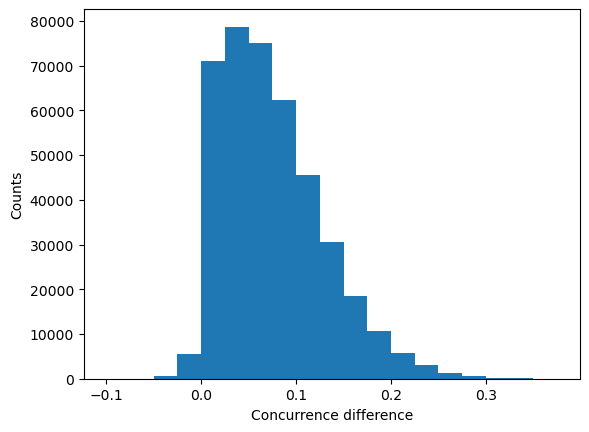

In [49]:
plt.xlabel('Concurrence difference')
plt.ylabel('Counts')
plt.grid(False)
plt.hist(all_complex.Measures.ConcurrenceDiff.values, bins = np.arange(-0.1, 0.4, 0.025))

In [60]:
all_complex.Measures.ConcurrenceDiff.describe()

count    409449.000000
mean          0.074852
std           0.054064
min          -0.079200
25%           0.033129
50%           0.065878
75%           0.106712
max           0.419246
Name: ConcurrenceDiff, dtype: float64

<Axes: xlabel='CHSH violation difference', ylabel='Counts'>

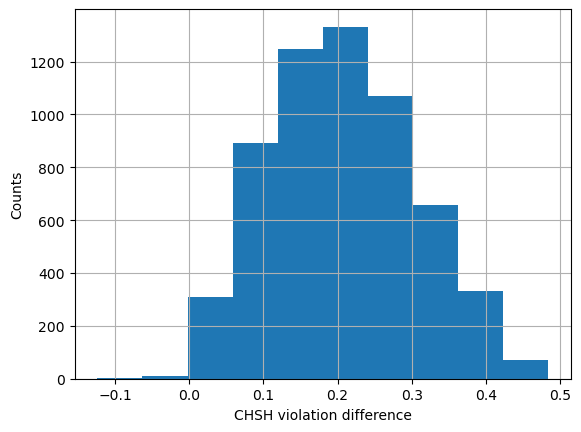

In [38]:
plt.xlabel('CHSH violation difference')
plt.ylabel('Counts')
all_complex.Measures.CHSHDiff.hist()

In [44]:
all_complex.Measures.ConcurrenceDiff